# Construction et Optimisation de portfeuille

## Import des bibliothèques et définition des paramètres globaux

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from scipy.optimize import minimize
plt.style.use("seaborn-v0_8")

# -----------------------------
# Paramètres globaux
# -----------------------------
start_date = "2022-10-25"
end_date   = "2025-11-25"

stocks = ["MSFT", "NVDA", "GOOGL", "AMZN", "META",
          "JNJ", "JPM", "COST", "PG", "XOM"]
cryptos = ["BTC-USD", "ETH-USD"]

tickers = stocks + cryptos

# Indices des cryptos dans le vecteur de poids
crypto_idx = [tickers.index(c) for c in cryptos]

# Taux sans risque annualisé (moyenne) : T-Bill 3 mois (daily)
rf_daily = web.DataReader("DTB3", "fred", start_date, end_date)
rf_daily = rf_daily.dropna()
rf = (rf_daily.mean().iloc[0] / 100).round(4)

trading_days = 252

## Téléchargement des données de marché (actions et cryptomonnaies)

In [2]:
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]

data = data.dropna(how="any")  # garder uniquement les dates où tout cote
data.head()

Ticker,AMZN,BTC-USD,COST,ETH-USD,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
Date,,,,,,,,,,,,
2022-10-25,120.599998,20095.857422,478.121674,1461.665405,103.764328,154.828613,113.957191,136.667465,244.118942,13.245088,121.315048,94.739388
2022-10-26,115.660004,20770.441406,478.495270,1566.566650,94.279739,156.189072,115.266724,129.024612,225.283676,12.880524,122.167931,95.866798
2022-10-27,110.959999,20285.835938,476.566162,1514.374878,91.588310,156.279770,115.721809,97.339935,220.832855,13.160189,122.260643,96.233665
2022-10-28,103.410004,20595.351562,490.319702,1555.477905,95.630424,158.601593,117.096367,98.592209,229.714874,13.817400,125.357025,99.052223
2022-10-31,102.440002,20495.773438,481.326630,1572.714478,93.862625,157.785324,116.910591,92.589218,226.072525,13.480804,124.847137,99.150658


## Calcul des rendements quotidiens et découpage in-sample / out-of-sample

In [3]:
# Rendements log quotidiens
returns = np.log(data / data.shift(1)).dropna()

# Découpage in-sample / out-of-sample
split_date = "2024-10-25"
eval_date   = "2025-10-25"

returns_in  = returns.loc[:split_date]
returns_out = returns.loc[split_date:eval_date]

returns_in.tail()

Ticker,AMZN,BTC-USD,COST,ETH-USD,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
Date,,,,,,,,,,,,
2024-10-21,0.000423,-0.015480,-0.003141,0.009105,0.003970,-0.013966,-0.010572,-0.002275,0.001482,0.040544,-0.010211,0.000583
2024-10-22,0.003327,-0.000096,0.007549,-0.017222,0.006500,0.003800,0.005010,0.011839,0.020632,-0.000835,0.000943,0.005150
2024-10-23,-0.026657,-0.013890,0.006337,-0.043326,-0.014394,0.014637,-0.003173,-0.031983,-0.006830,-0.028467,-0.000707,-0.003569
2024-10-24,0.009001,0.025692,-0.006415,0.010072,-0.000369,-0.013292,0.007003,0.007230,0.000306,0.006072,0.000236,-0.005670
2024-10-25,0.007750,-0.022532,-0.002465,-0.039666,0.015550,-0.017193,-0.011939,0.009588,0.008020,0.008016,-0.008288,-0.000837


## Statistiques descriptives et matrice de corrélation (plots pour le rapport)

,mu_annual,vol_annual
Ticker,,
AMZN,0.221969,0.328644
BTC-USD,0.600605,0.514910
COST,0.308709,0.200903
ETH-USD,0.255885,0.606105
GOOGL,0.230987,0.307958
JNJ,0.000099,0.158095
JPM,0.324294,0.206812
META,0.716738,0.443256
MSFT,0.276783,0.247796


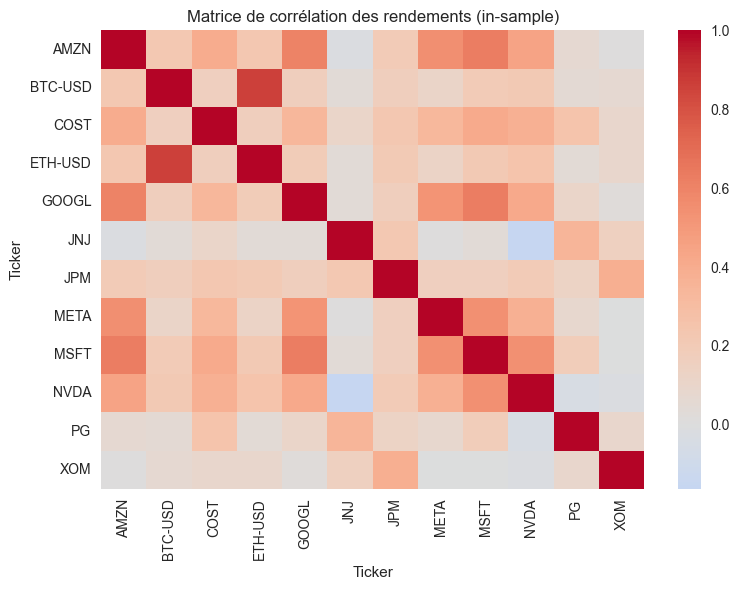

In [4]:
# Statistiques annualisées (in-sample)
mu_in  = returns_in.mean() * trading_days        # rendement attendu annuel
vol_in = returns_in.std() * np.sqrt(trading_days)  # volatilité annuelle
cov_in = returns_in.cov() * trading_days         # matrice de covariance annuelle

stats_df = pd.DataFrame({
    "mu_annual": mu_in,
    "vol_annual": vol_in
})

display(stats_df)

# Heatmap des corrélations
corr_mat = returns_in.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des rendements (in-sample)")
plt.tight_layout()
plt.show()

## Fonctions utilitaires pour le portefeuille (rendement, risque, Sharpe…)

In [5]:
# === Fonctions de base portefeuilles ===

def portfolio_return(weights, mu):
    return float(np.dot(weights, mu))


def portfolio_volatility(weights, cov):
    cov_np = np.array(cov)
    return float(np.sqrt(np.dot(weights.T, np.dot(cov_np, weights))))


def portfolio_sharpe(weights, mu, cov, rf):
    rp = portfolio_return(weights, mu)
    sp = portfolio_volatility(weights, cov)
    return (rp - rf) / sp


def max_drawdown(series):
    """
    series : série de valeurs de portefeuille (index temps)
    """
    cummax = series.cummax()
    dd = 1 - series / cummax
    return dd.max()


# === Risk contribution (utile pour Risk Parity) ===

def risk_contributions(weights, cov):
    """
    Retourne (variance_portefeuille, contributions_au_risque)
    RC_i = w_i * (Sigma w)_i
    """
    cov_np = np.array(cov)
    port_var = np.dot(weights, np.dot(cov_np, weights))
    mrc = np.dot(cov_np, weights)        # marginal risk contribution
    rc = weights * mrc                   # risk contributions
    return port_var, rc


## Fonction d’optimisation sous contraintes (somme=1, w_i<=30%, cryptos<=20%)

In [6]:
# === Contraintes & fonctions d'optimisation ===

n_assets = len(tickers)

# nouvelle définition des bornes, APRÈS avoir défini la liste tickers, stocks, cryptos
bounds = []
for t in tickers:
    if t in cryptos:
        bounds.append((0.00, 0.2))  # chaque crypto entre 0% et 15%
    else:
        bounds.append((0.00, 0.3))  # chaque action entre 0% et 25%

# contrainte somme des poids = 1
def weight_sum_constraint(weights):
    return np.sum(weights) - 1.0

# contrainte somme des cryptos <= 20%
def crypto_constraint(weights):
    return 0.20 - np.sum(weights[crypto_idx])


constraints = [
    {"type": "eq", "fun": weight_sum_constraint},
    {"type": "ineq", "fun": crypto_constraint},  # >= 0 -> w_crypto_total <= 0.20
]


def optimize_min_variance(mu, cov):
    x0 = np.array([1.0 / n_assets] * n_assets)

    def objective(weights):
        return portfolio_volatility(weights, cov) ** 2  # variance

    res = minimize(
        objective,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False}
    )
    return res.x


def optimize_max_sharpe(mu, cov, rf):
    x0 = np.array([1.0 / n_assets] * n_assets)

    def objective(weights):
        # on minimise le Sharpe négatif
        return -portfolio_sharpe(weights, mu, cov, rf)

    res = minimize(
        objective,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False}
    )
    return res.x


def optimize_risk_parity(cov):
    """
    Portefeuille Risk Parity (Equal Risk Contribution)
    sous les mêmes contraintes (somme=1, bornes, crypto <= 20%)
    """
    cov_np = np.array(cov)
    x0 = np.array([1.0 / n_assets] * n_assets)

    def objective(weights):
        port_var = np.dot(weights, np.dot(cov_np, weights))
        mrc = np.dot(cov_np, weights)
        rc = weights * mrc
        target = port_var / n_assets
        return np.sum((rc - target) ** 2)

    res = minimize(
        objective,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False}
    )
    return res.x


## Construction des portefeuilles : équipondéré, minimum variance, max Sharpe

In [7]:
# === Construction des portefeuilles ===

# Portefeuille équipondéré (en respectant la contrainte crypto <= 20% si possible)
w_equal = np.array([1.0 / n_assets] * n_assets)

# Ajustement grossier si la contrainte crypto n'est pas respectée
crypto_weight_eq = w_equal[crypto_idx].sum()
if crypto_weight_eq > 0.20:
    # on réduit proportionnellement les poids crypto et on redistribue vers les actions
    scale = 0.20 / crypto_weight_eq
    w_equal[crypto_idx] *= scale
    excess = (1.0 - w_equal.sum())  # ce qui manque pour sommer à 1
    # redistribuer l'excès sur les actions
    stock_idx = [i for i in range(n_assets) if i not in crypto_idx]
    w_equal[stock_idx] += excess / len(stock_idx)

# Portefeuille minimum variance (in-sample)
w_gmv = optimize_min_variance(mu_in.values, cov_in)

# Portefeuille max Sharpe
w_max_sharpe = optimize_max_sharpe(mu_in.values, cov_in, rf)

# Portefeuille Risk Parity
w_rp = optimize_risk_parity(cov_in)

# Portefeuille Mix (combinaison de GMV, Risk Parity et Max Sharpe)
w_mix = 0.33 * w_gmv + 0.33 * w_rp + 0.34 * w_max_sharpe

weights_df = pd.DataFrame({
    "Equal_Weight": w_equal,
    "GMV": w_gmv,
    "Max_Sharpe": w_max_sharpe,
    "Risk_Parity": w_rp,
    "Mix": w_mix
}, index=tickers)

display(weights_df)

,Equal_Weight,GMV,Max_Sharpe,Risk_Parity,Mix
MSFT,0.083333,1.343849e-03,0.000000e+00,0.086122,0.028864
NVDA,0.083333,1.240479e-02,7.481588e-02,0.056788,0.048271
GOOGL,0.083333,1.871965e-01,5.376717e-02,0.098238,0.112474
AMZN,0.083333,0.000000e+00,0.000000e+00,0.035078,0.011576
META,0.083333,1.954323e-02,0.000000e+00,0.090208,0.036218
JNJ,0.083333,3.000000e-01,1.580279e-16,0.099482,0.131829
JPM,0.083333,1.760066e-01,2.963148e-01,0.099445,0.191646
COST,0.083333,1.002887e-18,1.146580e-01,0.079233,0.065131
PG,0.083333,1.035050e-01,0.000000e+00,0.092851,0.064797
XOM,0.083333,0.000000e+00,2.604441e-01,0.062556,0.109194


## Tracé des poids du portefeuille optimal (Graphique pour le rapport)

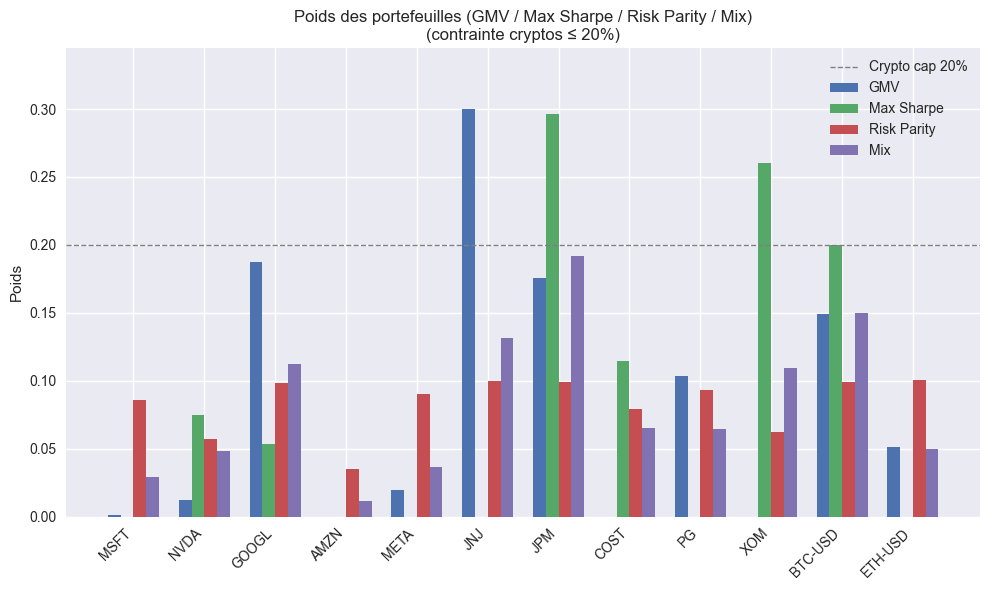

In [8]:
# === Comparaison des poids Max Sharpe vs Risk Parity ===

idx = np.arange(len(weights_df))
width = 0.18

plt.figure(figsize=(10, 6))
plt.bar(idx - 1.5*width, weights_df["GMV"], width=width, label="GMV")
plt.bar(idx - 0.5*width, weights_df["Max_Sharpe"], width=width, label="Max Sharpe")
plt.bar(idx + 0.5*width, weights_df["Risk_Parity"], width=width, label="Risk Parity")
plt.bar(idx + 1.5*width, weights_df["Mix"], width=width, label="Mix")

plt.xticks(idx, weights_df.index, rotation=45, ha="right")
plt.ylabel("Poids")
plt.title("Poids des portefeuilles (GMV / Max Sharpe / Risk Parity / Mix)\n(contrainte cryptos ≤ 20%)")
plt.axhline(0.20, color="gray", linestyle="--", linewidth=1, label="Crypto cap 20%")
top = max(weights_df.max().max(), 0.20) * 1.15
plt.ylim(0, top)
plt.legend()
plt.tight_layout()
plt.show()


## Backtest des portefeuilles (in-sample et out-of-sample) + benchmarks

In [9]:
# === Fonction valeur de portefeuille + Benchmarks ===

def portfolio_value(returns, weights, initial_value=1.0):
    port_rets = (returns * weights).sum(axis=1)
    value = (1 + port_rets).cumprod() * initial_value
    return value, port_rets

# Benchmarks : S&P 500 (SPY) + Bitcoin seul
bench_tickers = ["SPY", "BTC-USD"]
bench_data = yf.download(
    bench_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"].dropna(how="any")

bench_returns = np.log(bench_data / bench_data.shift(1)).dropna()

# Alignement des dates des portefeuilles avec celles des benchmarks
common_dates = returns.index.intersection(bench_returns.index)
rets_all = returns.loc[common_dates]
bench_returns = bench_returns.loc[common_dates]

rets_all_in  = rets_all.loc[:split_date]
rets_all_out = rets_all.loc[split_date:]
bench_in  = bench_returns.loc[:split_date]
bench_out = bench_returns.loc[split_date:]

# Valeurs in-sample
v_eq_in,  r_eq_in  = portfolio_value(rets_all_in, w_equal)
v_gmv_in, r_gmv_in = portfolio_value(rets_all_in, w_gmv)
v_ms_in,  r_ms_in  = portfolio_value(rets_all_in, w_max_sharpe)
v_rp_in,  r_rp_in  = portfolio_value(rets_all_in, w_rp)
v_mix_in, r_mix_in = portfolio_value(rets_all_in, w_mix)

# Valeurs out-of-sample
v_eq_out,  r_eq_out  = portfolio_value(rets_all_out, w_equal)
v_gmv_out, r_gmv_out = portfolio_value(rets_all_out, w_gmv)
v_ms_out,  r_ms_out  = portfolio_value(rets_all_out, w_max_sharpe)
v_rp_out,  r_rp_out  = portfolio_value(rets_all_out, w_rp)
v_mix_out, r_mix_out = portfolio_value(rets_all_out, w_mix)

# Benchmarks (S&P 500, BTC) in/out
v_spy_in,  r_spy_in  = portfolio_value(bench_in[["SPY"]], np.array([1.0]))
v_btc_in,  r_btc_in  = portfolio_value(bench_in[["BTC-USD"]], np.array([1.0]))

v_spy_out, r_spy_out = portfolio_value(bench_out[["SPY"]], np.array([1.0]))
v_btc_out, r_btc_out = portfolio_value(bench_out[["BTC-USD"]], np.array([1.0]))

## Graphiques de performance cumulée (in-sample et out-of-sample)

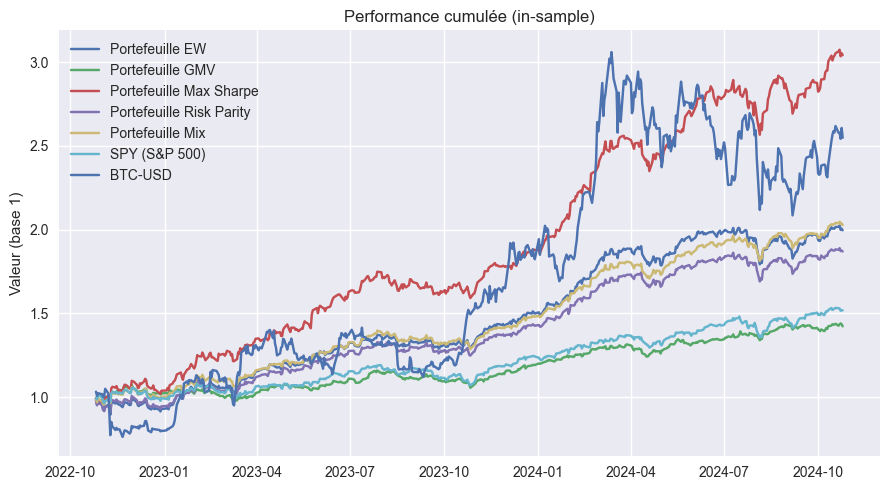

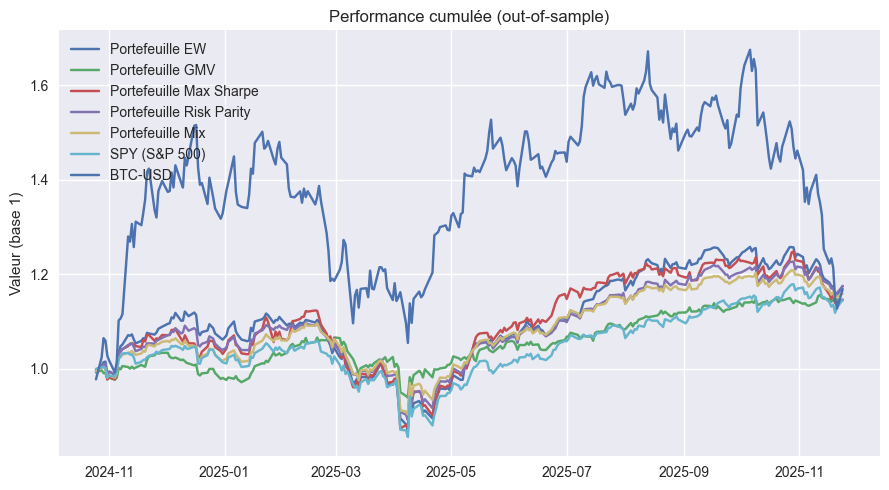

In [10]:
# === Performance cumulée in-sample ===

plt.figure(figsize=(9, 5))
plt.plot(v_eq_in,  label="Portefeuille EW")
plt.plot(v_gmv_in, label="Portefeuille GMV")
plt.plot(v_ms_in,  label="Portefeuille Max Sharpe")
plt.plot(v_rp_in,  label="Portefeuille Risk Parity")
plt.plot(v_mix_in, label="Portefeuille Mix")
plt.plot(v_spy_in, label="SPY (S&P 500)")
plt.plot(v_btc_in, label="BTC-USD")
plt.legend()
plt.title("Performance cumulée (in-sample)")
plt.ylabel("Valeur (base 1)")
plt.tight_layout()
plt.show()

# === Performance cumulée out-of-sample ===

plt.figure(figsize=(9, 5))
plt.plot(v_eq_out,  label="Portefeuille EW")
plt.plot(v_gmv_out, label="Portefeuille GMV")
plt.plot(v_ms_out,  label="Portefeuille Max Sharpe")
plt.plot(v_rp_out,  label="Portefeuille Risk Parity")
plt.plot(v_mix_out, label="Portefeuille Mix")
plt.plot(v_spy_out, label="SPY (S&P 500)")
plt.plot(v_btc_out, label="BTC-USD")
plt.legend()
plt.title("Performance cumulée (out-of-sample)")
plt.ylabel("Valeur (base 1)")
plt.tight_layout()
plt.show()

## Calcul des metrics de performance (r, vol, Sharpe, drawdown)

In [11]:
# === Metrics de performance (in & out) ===

def performance_metrics(port_rets, rf, freq=252):
    mu_annual = port_rets.mean() * freq
    vol_annual = port_rets.std() * np.sqrt(freq)
    sharpe = (mu_annual - rf) / vol_annual
    value = (1 + port_rets).cumprod()
    dd_max = max_drawdown(value)
    return mu_annual, vol_annual, sharpe, dd_max


rows = []
labels = [
    "EW_in", "GMV_in", "MaxSharpe_in", "RiskParity_in", "Mix_in",
    "SPY_in", "BTC_in",
    "EW_out", "GMV_out", "MaxSharpe_out", "RiskParity_out", "Mix_out",
    "SPY_out", "BTC_out"
]

rets_list = [
    r_eq_in, r_gmv_in, r_ms_in, r_rp_in, r_mix_in,
    r_spy_in, r_btc_in,
    r_eq_out, r_gmv_out, r_ms_out, r_rp_out, r_mix_out,
    r_spy_out, r_btc_out
]

for label, r in zip(labels, rets_list):
    mu_a, vol_a, s, dd = performance_metrics(r, rf)
    rows.append([label, mu_a, vol_a, s, dd])

perf_df = pd.DataFrame(
    rows,
    columns=["Portefeuille", "mu_annual", "vol_annual", "Sharpe", "Max_Drawdown"]
)
display(perf_df)

,Portefeuille,mu_annual,vol_annual,Sharpe,Max_Drawdown
0,EW_in,0.363965,0.186832,1.695994,0.108213
1,GMV_in,0.183066,0.111079,1.224049,0.089447
2,MaxSharpe_in,0.579013,0.206051,2.581465,0.112881
3,RiskParity_in,0.326795,0.161434,1.732558,0.092322
4,Mix_in,0.365118,0.147479,2.156369,0.079543
5,SPY_in,0.219129,0.139876,1.229862,0.101473
6,BTC_in,0.600605,0.514910,1.074955,0.318627
7,EW_out,0.170629,0.203417,0.607271,0.225660
8,GMV_out,0.133628,0.127730,0.677426,0.119498
9,MaxSharpe_out,0.151476,0.221857,0.470466,0.222457


## Courbe de drawdown du portefeuille Max Sharpe

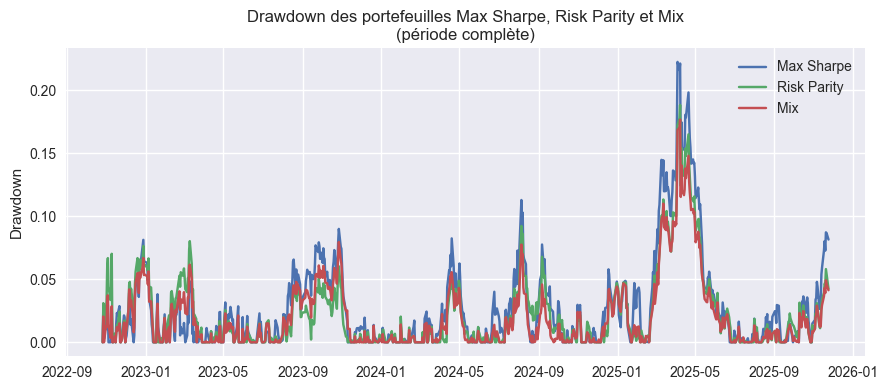

In [12]:
# === Drawdown sur la période complète : Max Sharpe vs Risk Parity vs Mix ===

v_ms_all, r_ms_all = portfolio_value(rets_all, w_max_sharpe)
v_rp_all, r_rp_all = portfolio_value(rets_all, w_rp)
v_mix_all, r_mix_all = portfolio_value(rets_all, w_mix)

cummax_ms = v_ms_all.cummax()
cummax_rp = v_rp_all.cummax()
cummax_mix = v_mix_all.cummax()

dd_ms = 1 - v_ms_all / cummax_ms
dd_rp = 1 - v_rp_all / cummax_rp
dd_mix = 1 - v_mix_all / cummax_mix

plt.figure(figsize=(9, 4))
plt.plot(dd_ms, label="Max Sharpe")
plt.plot(dd_rp, label="Risk Parity")
plt.plot(dd_mix, label="Mix")
plt.title("Drawdown des portefeuilles Max Sharpe, Risk Parity et Mix\n(période complète)")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

## Simulation aléatoire de portefeuilles et frontière efficiente

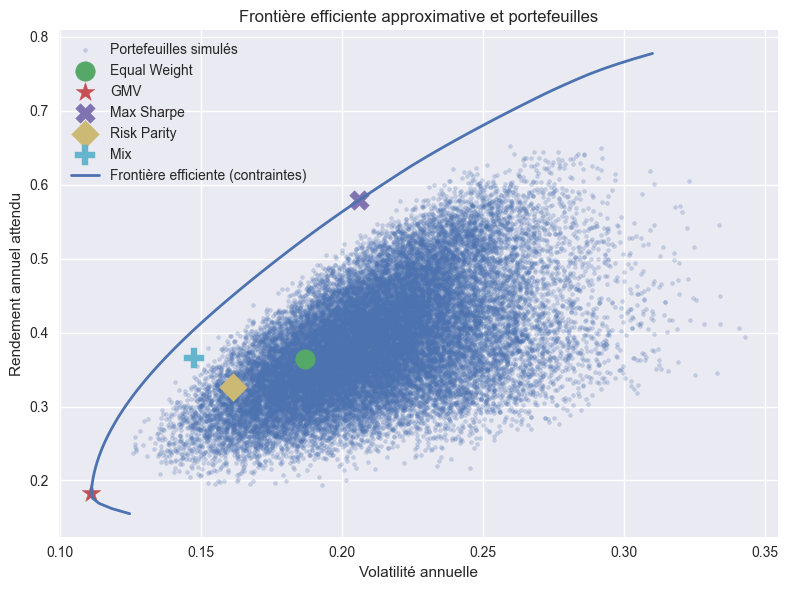

In [13]:
# === Simulation aléatoire de portefeuilles + Frontière efficiente contraignante ===

n_sim = 100000
sim_returns = []
sim_vols = []
sim_sharpes = []

for _ in range(n_sim):
    # initialisation : dirichlet pour avoir somme=1
    w = np.random.dirichlet(np.ones(n_assets))

    # rejeter si contraintes non respectées
    if (w > 0.30).any():
        continue
    if (w < 0.002).any():  # minimum 0.2% pour diversification
        continue
    if w[crypto_idx].sum() > 0.15:  # limite crypto à 15% pour la simu
        continue

    mu_p = portfolio_return(w, mu_in.values)
    vol_p = portfolio_volatility(w, cov_in)
    s_p = (mu_p - rf) / vol_p

    sim_returns.append(mu_p)
    sim_vols.append(vol_p)
    sim_sharpes.append(s_p)

sim_returns = np.array(sim_returns)
sim_vols = np.array(sim_vols)
sim_sharpes = np.array(sim_sharpes)

# ----------------------------------------------------
# Calcul de la frontière efficiente sous contraintes
# ----------------------------------------------------
target_returns = np.linspace(sim_returns.min() * 0.8, sim_returns.max() * 1.3, 100)

frontier_vols = []
frontier_rets = []

for tr in target_returns:
    # contrainte supplémentaire : rendement cible = tr
    def target_return_constraint(weights, mu=mu_in.values, tr=tr):
        return np.dot(weights, mu) - tr

    constraints_frontier = [
        {"type": "eq",   "fun": weight_sum_constraint},   # somme des poids = 1
        {"type": "ineq", "fun": crypto_constraint},       # w_crypto_total <= 0.20
        {"type": "eq",   "fun": target_return_constraint} # rendement cible
    ]

    x0 = np.array([1.0 / n_assets] * n_assets)

    def objective_var(weights):
        return portfolio_volatility(weights, cov_in) ** 2

    res = minimize(
        objective_var,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints_frontier,
        options={"disp": False, "maxiter": 500}
    )

    if res.success:
        w_opt = res.x
        vol_opt = portfolio_volatility(w_opt, cov_in)
        mu_opt  = portfolio_return(w_opt, mu_in.values)
        frontier_vols.append(vol_opt)
        frontier_rets.append(mu_opt)

frontier_vols = np.array(frontier_vols)
frontier_rets = np.array(frontier_rets)

# ----------------------------------------------------
# Plot : nuage + EW + GMV + Max Sharpe + Risk Parity + Mix + Frontière
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(sim_vols, sim_returns, alpha=0.25, s=8, label="Portefeuilles simulés")

# Equal Weight
plt.scatter(
    portfolio_volatility(w_equal, cov_in),
    portfolio_return(w_equal, mu_in.values),
    marker="o",
    s=200,
    label="Equal Weight"
)

# GMV
plt.scatter(
    portfolio_volatility(w_gmv, cov_in),
    portfolio_return(w_gmv, mu_in.values),
    marker="*",
    s=200,
    label="GMV"
)

# Max Sharpe
plt.scatter(
    portfolio_volatility(w_max_sharpe, cov_in),
    portfolio_return(w_max_sharpe, mu_in.values),
    marker="X",
    s=200,
    label="Max Sharpe"
)

# Risk Parity
plt.scatter(
    portfolio_volatility(w_rp, cov_in),
    portfolio_return(w_rp, mu_in.values),
    marker="D",
    s=200,
    label="Risk Parity"
)

# Mix
plt.scatter(
    portfolio_volatility(w_mix, cov_in),
    portfolio_return(w_mix, mu_in.values),
    marker="P",
    s=200,
    label="Mix"
)

# Frontière efficiente (ligne)
plt.plot(
    frontier_vols,
    frontier_rets,
    linewidth=2,
    label="Frontière efficiente (contraintes)"
)

plt.xlabel("Volatilité annuelle")
plt.ylabel("Rendement annuel attendu")
plt.title("Frontière efficiente approximative et portefeuilles")
plt.legend()
plt.tight_layout()
plt.show()

## Performance des portefeuilles sur la période du challenge (25/10/2025–25/11/2025)

Nb de jours dans la période du challenge : 21


,Portefeuille,Rendement Mensuel (%),Volatilité Annuelle,Max Drawdown
0,GMV,-0.088964,0.068718,0.014438
1,Max Sharpe,-5.579645,0.172477,0.087238
2,Risk Parity,-2.940446,0.137018,0.058068
3,Mix,-2.897431,0.107844,0.049183
4,SPY,-1.346985,0.150255,0.051354
5,BTC-USD,-21.189282,0.428431,0.260065


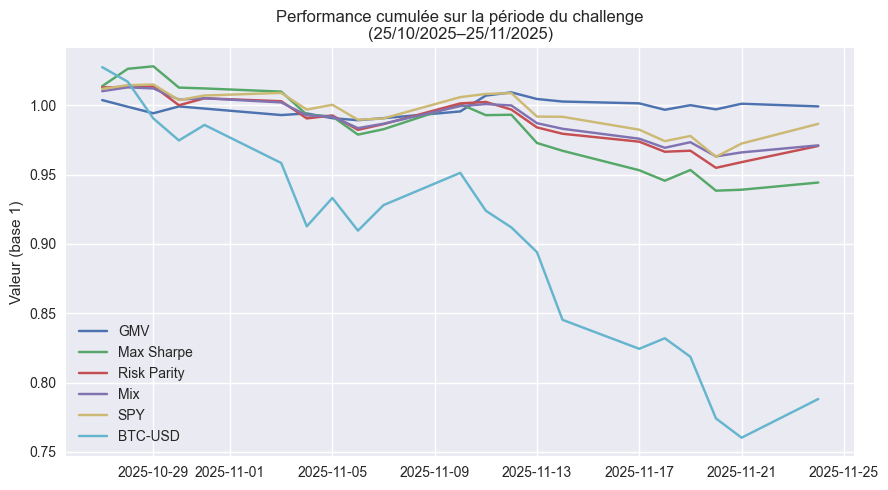

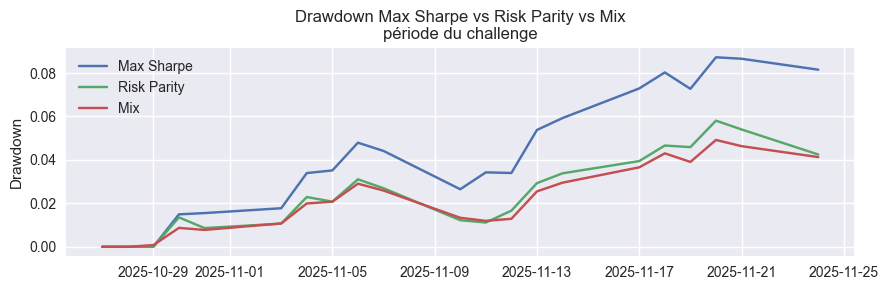

In [19]:
# === Performance sur la période du challenge : 25/10/2025–25/11/2025 ===

eval_start = "2025-10-25"
eval_end   = "2025-11-25"

eval_rets   = returns.loc[eval_start:eval_end]
eval_bench  = bench_returns.loc[eval_start:eval_end]   # SPY, BTC-USD

print("Nb de jours dans la période du challenge :", eval_rets.shape[0])


# Valeurs de portefeuille
v_gmv_eval,  r_gmv_eval  = portfolio_value(eval_rets, w_gmv)
v_ms_eval,   r_ms_eval   = portfolio_value(eval_rets, w_max_sharpe)
v_rp_eval,   r_rp_eval   = portfolio_value(eval_rets, w_rp)
v_mix_eval,  r_mix_eval  = portfolio_value(eval_rets, w_mix)

# Benchmarks
v_spy_eval,  r_spy_eval  = portfolio_value(eval_bench[["SPY"]], np.array([1.0]))
v_btc_eval,  r_btc_eval  = portfolio_value(eval_bench[["BTC-USD"]], np.array([1.0]))

# Rendements mensuels (réels) pour la période du challenge
R_gmv = (1 + r_gmv_eval).prod() - 1
R_ms  = (1 + r_ms_eval).prod()  - 1
R_rp  = (1 + r_rp_eval).prod()  - 1
R_mix = (1 + r_mix_eval).prod() - 1
R_spy = (1 + r_spy_eval).prod() - 1
R_btc = (1 + r_btc_eval).prod() - 1

# Volatilités annuelles sur la période
vol_gmv = r_gmv_eval.std() * np.sqrt(trading_days)
vol_ms  = r_ms_eval.std()  * np.sqrt(trading_days)
vol_rp  = r_rp_eval.std()  * np.sqrt(trading_days)
vol_mix = r_mix_eval.std() * np.sqrt(trading_days)
vol_spy = r_spy_eval.std() * np.sqrt(trading_days)
vol_btc = r_btc_eval.std() * np.sqrt(trading_days)

# Max drawdown sur la période
dd_gmv = max_drawdown((1 + r_gmv_eval).cumprod())
dd_ms  = max_drawdown((1 + r_ms_eval).cumprod())
dd_rp  = max_drawdown((1 + r_rp_eval).cumprod())
dd_mix = max_drawdown((1 + r_mix_eval).cumprod())
dd_spy = max_drawdown((1 + r_spy_eval).cumprod())
dd_btc = max_drawdown((1 + r_btc_eval).cumprod())

# Tableau des performances sur la période du challenge
perf_df_eval = pd.DataFrame({
    "Portefeuille": [
         "GMV", "Max Sharpe", "Risk Parity", "Mix", "SPY", "BTC-USD"
    ],
    "Rendement Mensuel (%)": [
     R_gmv * 100, R_ms * 100, R_rp * 100, R_mix * 100, R_spy * 100, R_btc * 100
    ],
    "Volatilité Annuelle": [
        vol_gmv, vol_ms, vol_rp, vol_mix, vol_spy, vol_btc
    ],
    "Max Drawdown": [
        dd_gmv, dd_ms, dd_rp, dd_mix, dd_spy, dd_btc
    ]
})

display(perf_df_eval)

# Courbe de performance sur la période du challenge
plt.figure(figsize=(9, 5))
plt.plot(v_gmv_eval, label="GMV")
plt.plot(v_ms_eval,  label="Max Sharpe")
plt.plot(v_rp_eval,  label="Risk Parity")
plt.plot(v_mix_eval, label="Mix")
plt.plot(v_spy_eval, label="SPY")
plt.plot(v_btc_eval, label="BTC-USD")
plt.title("Performance cumulée sur la période du challenge\n(25/10/2025–25/11/2025)")
plt.ylabel("Valeur (base 1)")
plt.legend()
plt.tight_layout()
plt.show()

# Drawdown du portefeuille Max Sharpe vs Risk Parity vs Mix sur la période du challenge
cummax_ms_eval = v_ms_eval.cummax()
cummax_rp_eval = v_rp_eval.cummax()
cummax_mix_eval = v_mix_eval.cummax()
dd_ms_eval = 1 - v_ms_eval / cummax_ms_eval
dd_rp_eval = 1 - v_rp_eval / cummax_rp_eval
dd_mix_eval = 1 - v_mix_eval / cummax_mix_eval

plt.figure(figsize=(9, 3))
plt.plot(dd_ms_eval, label="Max Sharpe")
plt.plot(dd_rp_eval, label="Risk Parity")
plt.plot(dd_mix_eval, label="Mix")
plt.title("Drawdown Max Sharpe vs Risk Parity vs Mix\npériode du challenge")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()